<a href="https://colab.research.google.com/github/EduardoPach/Chemical_Engineering/blob/main/2D_Heat_Condutction/Dynamic_2D_Conduction_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation
import ipywidgets as wg
from scipy import interpolate
from IPython import display
import time
plt.style.use("classic")

# Transient 2D Conduction
In this notebook our goal will be to simulate the transient response of a 2D heat conduction on a plate. Our governing heat equation is:

$$\frac{\partial T}{\partial t} = \alpha \left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right)$$


Our heat equation is a PDE (Parital Differential Equation), thus its solution isn't as easy like the ones from ordinary differential equations (ODEs), because of the addition of spatial dimensions. One way to solve this equation is to **discretize the spatial components** reducing our PDE to a system of ODEs that we can easily solve. We've more than one way to discriteze the spatial domain, such as: finite difference method (FDM), finite element method (FEM), finite volume method (FVM). Each one of this methods have their own particularities, but we won't get into it. To keep it simple we'll use the FDM to discriteze our domain.

## Finite Difference Method:

The idea behind finite difference method is to divide our domain by adding points to it, then we use this points to approximate our derivatives as if they were simple divisions like: $\frac{df}{dx}\approx\frac{\Delta f}{\Delta x}$. When we add a bunch of points to discretize our domain the smaller the distance between points will get, thus representing better the temperautre profile. Below we have a quick demonstration of how a plate would be discretize with 3 points (dividing the width and height by 4) having boundaries $T_A$,$T_B$,$T_C$,$T_D$

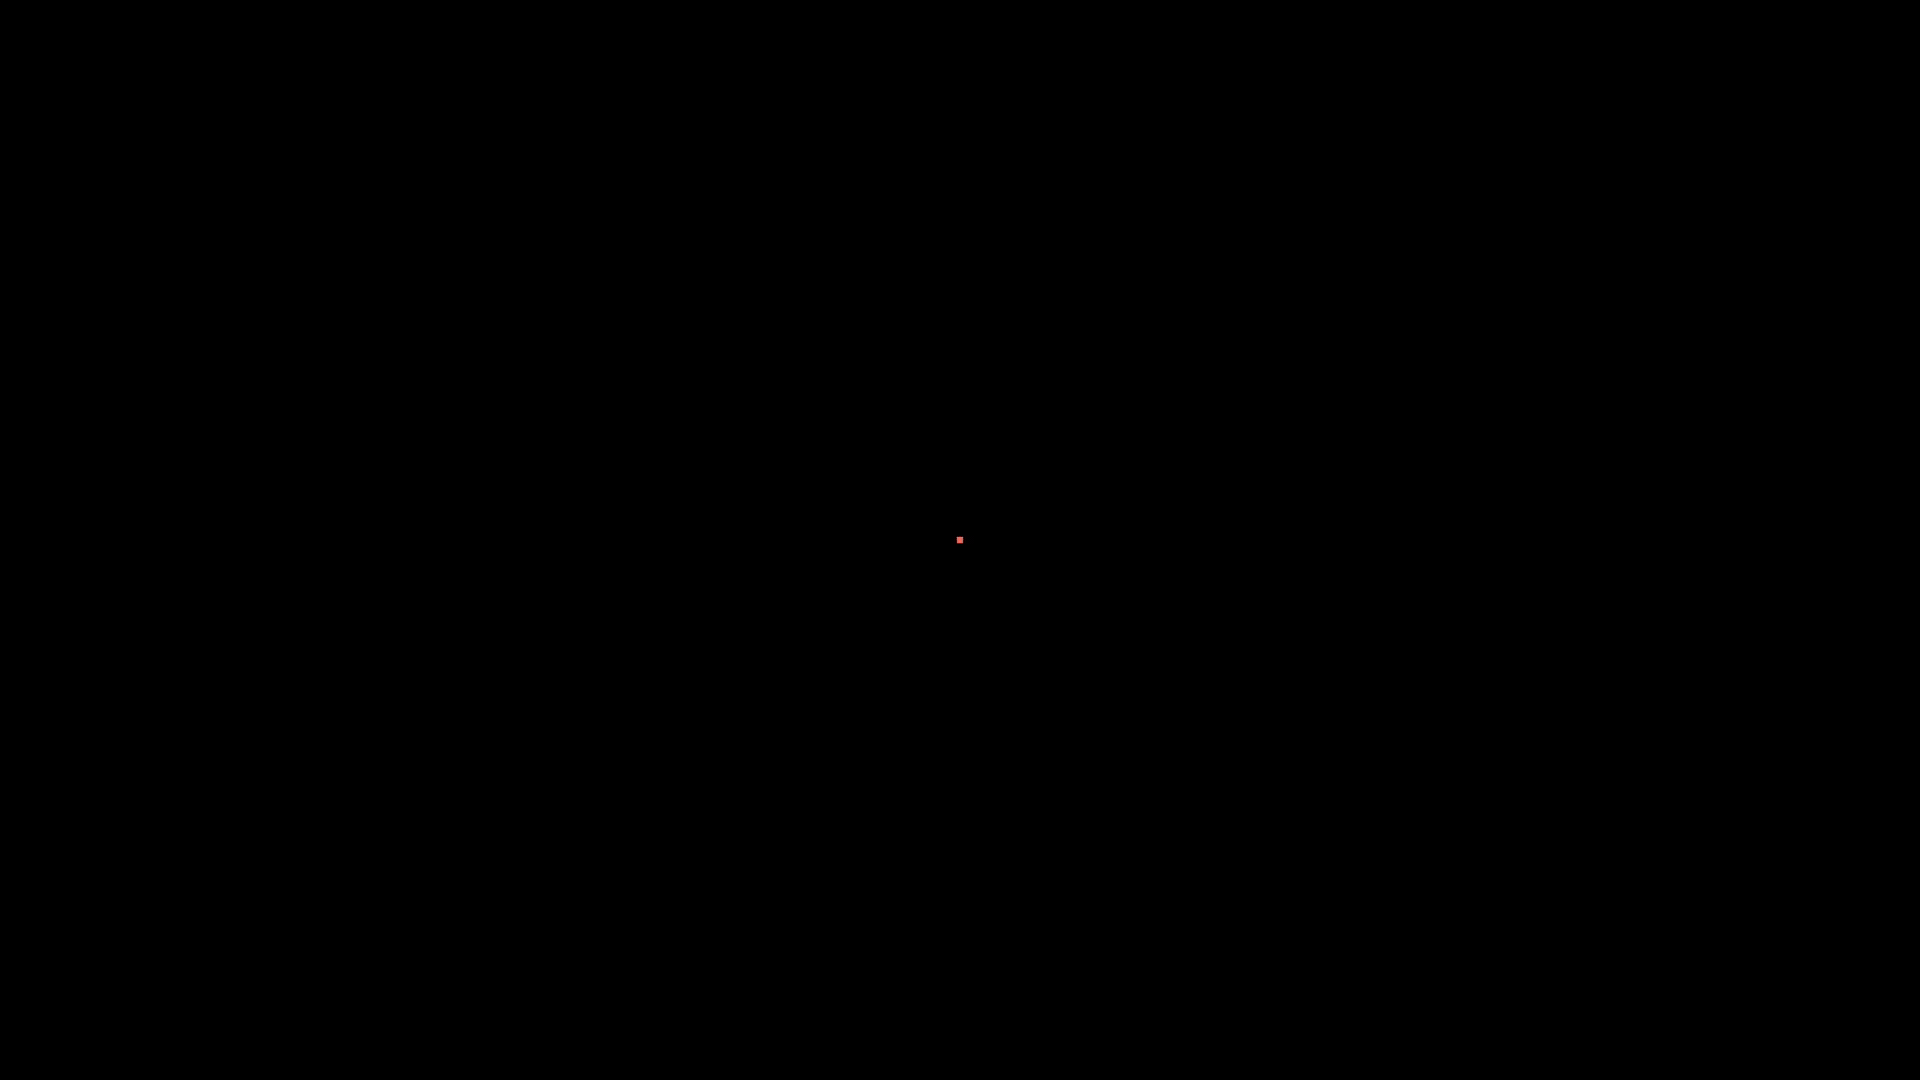


Second Derivative Definition:

$$\frac{d^2f}{dx^2} \approx \frac{f_{i-1}-2f_i+f_{i+1}}{\Delta x^2}$$

Therefore, our discritezed domain is:

$$\begin{align}
\frac{\partial^2 T}{\partial x^2} &= \frac{T_{i-1,j}-2T_{i,j}+T_{i+1,j}}{\Delta x^2} \\
\frac{\partial^2 T}{\partial y^2} &= \frac{T_{i,j-1}-2T_{i,j}+T_{i,j+1}}{\Delta y^2}
\end{align}$$

so our discritezed equation simplifies to:

$$\frac{dT}{dt} = \alpha\left(\frac{T_{i-1,j}-2T_{i,j}+T_{i+1,j}}{\Delta x^2}+\frac{T_{i,j-1}-2T_{i,j}+T_{i,j+1}}{\Delta y^2} \right)$$

Where, indexes i and j refer to the x and y position respectively and $\alpha$ is the thermal diffusivity, we'll assume that our plate is isotropic, i.e. $\alpha$ is constant in our domain. In the table below we can see the thermal diffusivity of some metals provided in the book **Fundamentals of Heat and Mass Transfer**.

| Material | Thermal Diffusivity ($\alpha$) | Unit | 
| :------- | :-----------------------------: |:---- | 
|Copper    |117 |$\frac{mm^2}{s}$      |
|Gold      |127 | $\frac{mm^2}{s}$    |
|Silver     |174 |     $\frac{mm^2}{s}$ |                     
|Aluminum  |97.1 |      $\frac{mm^2}{s}$|
|Iron      |23.1|      $\frac{mm^2}{s}$|
|Stainless Steel AISI 304  |3.95|      $\frac{mm^2}{s}$|
|Cobalt|26.6|      $\frac{mm^2}{s}$|
|Magnesium|87.6|      $\frac{mm^2}{s}$|
|Molybdenum|53.7|      $\frac{mm^2}{s}$|
|Zinc|41.8|      $\frac{mm^2}{s}$|


In [11]:
####################### CREATING DICT WITH THERMAL CONDUCT OF METALS #######################
Thermal_Conductivities = dict(Copper=117e-6,Gold=127e-6,Silver=174e-6,
                              Aluminum=97.1e-6,Iron=23.1e-6,Magnesium=87.6e-6,
                              Steel=3.95e-6,Cobalt=26.6e-6,Molybdenum=53.7e-6,
                             Zinc=41.8e-6)

## Understanding How to Apply Discretization

Now that we reduced our PDE we need to come up with a way to efficiently calculate the finite differences for an arbitrary number of points that we want to add to our domain (just keep everything clear, whenever "number of points" come up this mean the number of points where we'll calculate the finite differences). Given a matrix with the boundary conditions and initial temperature condition, we have two alternatives to calculate the differences at each points:

### First Alternative:

Use a nested for loop that iterates through every point position and calculate the finite differences and returns time derivates for each point on the grid. Let's try this method on the following matrix:

$$A = \begin{bmatrix}
10 & 10 & 10 & 10 & 10\\
20 & 5 & 5 & 5 & 30 \\
20 & 5 & 5 & 5 & 30 \\
20 & 5 & 5 & 5 & 30 \\
40 & 40 & 40 & 40 & 40
\end{bmatrix}$$

We can see that we have a 5x5 matrix with number of points equal to 3 for the x and y axis with temperature boundaries 10°C,20°C,30°C and 40° and initial temperature of 5°C. Now let's apply the nested loop to discretize our domain let's also assume that the plate it's made of Copper and it has 30cm of width and height.

In [6]:
####################### Plate Dimensions #######################
H = 0.3
W = 0.3

In [ ]:
A = np.ones((5,5))

A[:,0] = 20 # LEFT
A[:,-1] = 30 # RIGHT
A[-1,:] = 40 # BOTTOM
A[0,:] = 10 # TOP
A[1:-1,1:-1] = 5 # INITIAL COND

delta_x = W/(3+1) # WHEN WE HAVE N POINTS THE NUMBER OF ELEMENTS OF EQUAL LENGHT IS N+1
delta_y = H/(3+1) # WHEN WE HAVE N POINTS THE NUMBER OF ELEMENTS OF EQUAL LENGHT IS N+1

discretized_A_I= np.ones((3,3)) # NUMBER OF POINTS TO CALCULATE FINITE DIFFERENCES
for i in range(A.shape[0]-2):
    for j in range(A.shape[1]-2):
        discretized_A_I[i,j] = Thermal_Conductivities["Copper"]*((A[i+1,j]-2*A[i+1,j+1]+A[i+1,j+2])/delta_x**2 +
                                (A[i,j+1]-2*A[i+1,j+1]+A[i+2,j+1])/delta_y**2)

        
discretized_A_I

array([[0.416, 0.104, 0.624],
       [0.312, 0.   , 0.52 ],
       [1.04 , 0.728, 1.248]])

### Second Alternative

Use shifted matrices sum to calculate each point finite difference at once. For those familiar with image processing this could actually be seen as a convolution. Let's apply this idea to the same matrix A as we did for the first alternative.

In [ ]:
discretized_A_II = Thermal_Conductivities["Copper"]*((A[1:-1,0:-2]-2*A[1:-1,1:-1]+A[1:-1,2:])/delta_x**2 + 
                                                     (A[0:-2,1:-1]-2*A[1:-1,1:-1]+A[2:,1:-1])/delta_y**2)
discretized_A_II

array([[0.416, 0.104, 0.624],
       [0.312, 0.   , 0.52 ],
       [1.04 , 0.728, 1.248]])

### Choosing Between Alternatives

Between both alternatives we'll keep the second one because it will be more efficient for higher values of points in our grid

In [7]:
def DiscretizedEquation(y,t,plate,nx,ny,material):
    """
    Makes the discretization of the 2D heat conduction for a plate and returns time derivates of each point.

    ##Arguments:
    y:Dummy argument
    Work around through odeint dimension problems
    t:Dummy argument
    Required as argument to be solved by odeint 
    plate: 2D array
    2D array representing the plate to be discretized
    nx: integer
    Number of discretization points on the x-axis (not including boundary). 
    ny:
    Number of discretization points on the y-axis (not including boundary).
    material: string
    Name of plate's material
    """
    
    dx = W/(nx+1) # When we add npoints to our dimension we are creating npoints+1 elemtns of equal size
    dy = H/(ny+1) # When we add npoints to our dimension we are creating npoints+1 elemtns of equal size
    d2Tdx2 = (plate[1:-1,0:-2]-2*plate[1:-1,1:-1]+plate[1:-1,2:])/dx**2
    d2Tdy2 = (plate[0:-2,1:-1]-2*plate[1:-1,1:-1]+plate[2:,1:-1])/dy**2
    
    dTdt = Thermal_Conductivities[material]*(d2Tdx2+d2Tdy2)

    return dTdt.flatten() # Flatting 2D array to 1D because of odeint.

## Simulation 


To create the simulation function we need to have in mind that, because we chose not to discretize the time domain as well as we did with the spatial domain we'll have to **pass the time derivatives values of each point to an integrator** and a good integrator choice is the **odeint function from scipy**. Since our discretization function reduces our input matrix dimension and **odeint** requires that the initial condition and function output have same dimensions. Therefore,we've added to the **DiscretizedEquation** function a dummy argument "y" (since it's required by **odeint**) and a "plate" argument to be passed as an input through **odeint** and really calculate the time derivatives to be provided to the integrator.

In [8]:
def Simulation(nx,ny,t,T0,bnds,material="Copper"):
    """
    Solve the transient discretized 2D heat conduction on a plate.

    ##Arguments: 
    nx: integer 

    ny: integer 
    Number of discretization points on the y-axis (not including boundary).
    t: array
    Time to calculate temperatures.
    T0: float
    Initial temperature of plate.
    bnds: array or float
    Boubndary's temperature.
    material: String
    Name of plate's material
    """
    matrix = np.ones((len(t),nx+2,ny+2))
    ############## BOUNDARY CONDITIONS ##############
    if isinstance(bnds,list):
        matrix[:,:,0]  = bnds[0]  # Left 
        matrix[:,0,:]  = bnds[1]  # Top 
        matrix[:,:,-1] = bnds[2]  # Right
        matrix[:,-1,:] = bnds[3]  # Bottom 
    else:
        matrix[:,:,0]  = bnds  # Left 
        matrix[:,0,:]  = bnds  # Top 
        matrix[:,:,-1] = bnds  # Right
        matrix[:,-1,:] = bnds  # Bottom
    ############## INITIAL CONDITION ##############
    matrix[0,1:-1,1:-1] = T0
    ############## SIMULATION ##############
    for i in range(len(t)-1):
        dt = [t[i],t[i+1]]
        profile = matrix[i,:,:] # Actual argument that is used to calculate the temperature rate of change.
        T0 = matrix[i,1:-1,1:-1].flatten() # 1D intial condition as required by odeint
        inputs = (profile,nx,ny,material)
        T = odeint(DiscretizedEquation,T0,dt,args=inputs)[-1].reshape(nx,ny)
        matrix[i+1,1:-1,1:-1] = T
    return matrix

## Testing Function

Now that we've created our function we can test it to see if it's running without raising any erros.

In [ ]:
%%time
nx = 50
ny = 50
bnds = [60,15,5,30]
T0 = 10
t = np.linspace(0,100,10000)
material="Silver"

Sim = Simulation(nx,ny,t,T0,bnds,material)


Wall time: 9.01 s


## Creating Plotting Function

Now we know that our function has apparently no erros let's create a plotting function to see what we're getting from the **Simulation** function.

In [9]:
def Plotting(nx,ny,T_0,tf,nt,material):
    """
    nx: integer
        Number of points in the x-axis.
    ny: integer
        Number of points in the y-axis.
    T_0: float
        Initial temperature value of the points.
    tf: float
        End simulation time.
    nt: integer
        Number of time points.
    material: string
        Name plate's material.
    """
    
    bnds=[30,15,5,60] # You can change the bounds here if you want
    
    t = np.linspace(0,tf,nt)
    x = np.linspace(0,W,nx+2)
    y = np.linspace(0,H,ny+2)
    
    Y,X = np.meshgrid(y,x)
    
    Temperature_Profile = Simulation(nx,ny,t,T_0,bnds,material)
    
    fig,axes = plt.subplots(1,4,figsize=(20,6))
    axes = axes.flatten()
    cs = [0,0,0,0]
    for count,ax in enumerate(axes):
        
        cs[count] = ax.contourf(X,Y,Temperature_Profile[int(count*(nt-1)/(3)),:,:])
        ax.set_title("Temperature Profile at t = {:.0f} s".format(t[int(count*(nt-1)/(3))]),fontsize=13,fontweight="bold")
        ax.set_xlabel("Width",fontsize=13)
        
        
    
    axes[0].set_ylabel("Height",fontsize=13)
    plt.tight_layout(pad=0.5)
    cbar = plt.colorbar(cs[-1],ax=axes)
    cbar.set_label("Temperature (°C)")

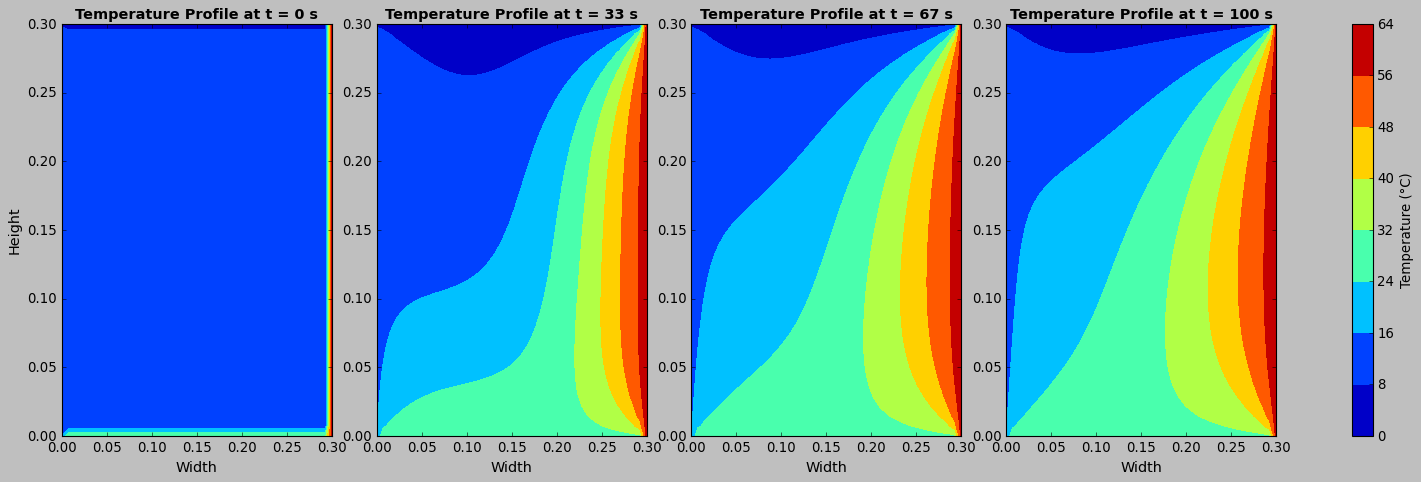

In [ ]:
Plotting(40,40,10,100,1000,"Gold")

Great! It seems our function isn't spitting nonsense. We can see that the region closer to the colder area takes more time to have its temperature increased, actually from t = 0 to t = 33 we can see a temperature decrease near the top of the plate, but this stops as soon as the heat from the right side of the plate "reaches" that region. Everything is nice, but it would be cooler to see that in an animation...

## Creating Simple Animation

In [ ]:
x = np.linspace(0,W,nx+2)
y = np.linspace(0,H,ny+2)
Y,X = np.meshgrid(y,x)


fig = plt.figure(figsize=(10,4))
ax = plt.axes(xlim=(0, W), ylim=(0, H), xlabel='x', ylabel='y')

cont = plt.contourf(X,Y,Sim[0,:,:])
cbar = plt.colorbar()
cbar.set_label("Temperature (°C)")
plt.grid()

def animate(i):
    global cont
    
    for c in cont.collections:
        c.remove()
        
    cont = plt.contourf(X,Y,Sim[i*100,:,:])
    plt.title("Temperature Profile of a "+material+" Plate at t={:.0f}s".format(t[i*100]),
             fontsize=15,
             fontweight="bold")
    
    return cont

anim = FuncAnimation(fig, animate, frames=int(len(t)/100), repeat=True)
# In case you want to save it
# anim.save("file_path,writer="ffmpeg")
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

## Playing with Simulation Arguments

Play yourself with the arguments from our function and see the impact of changing arguments. 

### Warning !
Have in mind that if you add a high number of points you might need to add more time points as well (i.e. reduce timestep) in order to converge.

In [12]:
######################## CREATING WIDGETS #########################
Nx_slider = wg.IntSlider(value=10,min=2,max=100,description="Nx");
Ny_slider = wg.IntSlider(value=10,min=2,max=100,description="Ny");
Material_drop = wg.Dropdown(options=Thermal_Conductivities.keys(),value="Copper",description="Material");
T0 = wg.FloatSlider(value=10,min=-10,max=100,description="T0");
tf_slider = wg.FloatSlider(value=10,min=5,max=500,description="End time");
Nt_slider = wg.IntSlider(value=100,min=30,max=100000,description="Nt");
####################### CREATING INTERACTION #######################
wg.interact(Plotting,
            nx=Nx_slider,
            ny=Ny_slider,
            T_0=T0,
            tf=tf_slider,
            nt=Nt_slider,
            material=Material_drop);

interactive(children=(IntSlider(value=10, description='Nx', min=2), IntSlider(value=10, description='Ny', min=…

## Looking at Function Performance

We've mentioned that the Second Alternative to discretize our domain was a better choice than the first one, since it would run a lot faster for higher number of points, so let's take a look at our function performance.

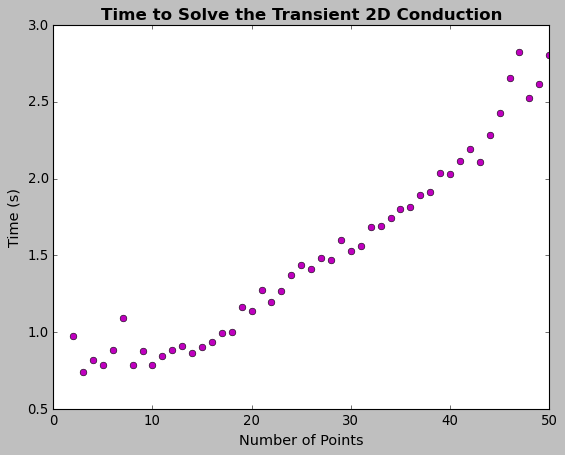

In [ ]:
# This may take a while
points = np.arange(2,51,1)
tstep = np.linspace(0,101,2500) # 2500 time points to avoid numerical problems.
timed = list() # List to store time values from our simulation.
for i in points:
    t0 = time.time()
    s = Simulation(i,i,tstep,T0,bnds,material)
    t = time.time()
    timed.append(t-t0)
    
plt.plot(points,timed,'om')
plt.xlabel("Number of Points",fontsize=13)
plt.ylabel("Time (s)",fontsize=13)
plt.title("Time to Solve the Transient 2D Conduction",fontsize=15,fontweight="bold");

We can see that we take about 3 seconds to solve a problem with 50 points on each axis, which is a fairly good time. The processing time increases due to the fact that the number of equations we're solving is $N_{Eq} = n_xn_y$ and since we're using $n_x=n_y$ our number of equation is equal to $N_{Eq} = n_{points}^2$, thus taking more time to solve. Furthermore, we've used the same number of timepoints for each simulation, however smaller number of points don't need a timestep as small as we've used in this analysis, so we can expect even lower times for smaller number of points

## Mesh Convergence

Okay, now let's take a deeper look at the effect of number of points in the result quality, to do that we'll run a bunch of different number of points condition and sample three points in our plate to get the temperature and compare those values.

### WARNING!!

The below cell code may take a while to run

In [ ]:
material = 'Silver'
npoints = np.arange(5,41,1) # number of points ranging from 5 to 40.
profile_storage = [] # store the temperature profile for the last time point.
x_list = [] # store size of delta x for each simulation
y_list = [] # store size of delta y for each simulation
points_storage = np.ones((len(npoints),3)) # matrix to store time and temperature at each point

# Change the Following values if you want to change point A, B and C locations
p1 = 0.05 # point A
p2 = 0.15 # point B
p3 = 0.25 # point C

for count,val in enumerate(npoints):
    n_x = val
    n_y = val
    x = np.linspace(0,W,n_x+2)
    y = np.linspace(0,H,n_y+2)
    
    y_list.append(y)
    x_list.append(x)
    
    temp_profile = Simulation(n_x,n_y,t,T0,bnds,"Silver")
    profile_storage.append(temp_profile[-1,:,:]) #
    interp_profile = interpolate.interp2d(x,y,temp_profile[-1,:,:])
    
    points_storage[count,0] = interp_profile(p1,p1) 
    points_storage[count,1] = interp_profile(p2,p2)
    points_storage[count,2] = interp_profile(p3,p3)

In [ ]:
Y,X = np.meshgrid(y_list[0],x_list[0])

fig = plt.figure(figsize=(20,6))

ax = plt.subplot(1,2,1)

cont = ax.contourf(X,Y,profile_storage[0])
plt.xlabel("Width")
plt.ylabel("Height")
cbar = plt.colorbar(cont)
cbar.set_label("Temperature (°C)")

plt.plot(p1,p1,'ok',markersize=9)
plt.plot(p2,p2,'ok',markersize=9)
plt.plot(p3,p3,'ok',markersize=9)

plt.annotate("A ({:.2f},{:.2f})".format(p1,p1),(p1,p1),(p1-0.01,p1+0.01),fontsize=14,fontweight="bold")
plt.annotate("B ({:.2f},{:.2f})".format(p2,p2),(p2,p2),(p2-0.01,p2+0.01),fontsize=14,fontweight="bold")
plt.annotate("C ({:.2f},{:.2f})".format(p3,p3),(p3,p3),(p3-0.01,p3+0.01),fontsize=14,fontweight="bold")

ax1 = plt.subplot(3,2,2)
ax1.set_ylim(np.min(points_storage[:,0])-0.01,np.max(points_storage[:,0])+0.01)
ax1.set_xlim(npoints[0],npoints[-1])

line1, = ax1.plot([],[],marker='o')
plt.title("Point A Temperature Value",fontsize=12,fontweight='bold')
plt.xticks([])
plt.ticklabel_format(useOffset=False)

ax2 = plt.subplot(3,2,4)
ax2.set_ylim(np.min(points_storage[:,1])-0.01,np.max(points_storage[:,1])+0.01)
ax2.set_xlim(npoints[0],npoints[-1])

line2, = ax2.plot([],[],marker='o')
plt.title("Point B Temperature Value",fontsize=12,fontweight='bold')
plt.xticks([])
plt.ticklabel_format(useOffset=False)

ax3 = plt.subplot(3,2,6)
ax3.set_ylim(np.min(points_storage[:,2])-0.01,np.max(points_storage[:,2])+0.01)
ax3.set_xlim(npoints[0],npoints[-1])

line3, = ax3.plot([],[],marker='o')
plt.title("Point C Temperature Value",fontsize=12,fontweight='bold')
plt.xlabel("Number of points")
plt.ticklabel_format(useOffset=False);

plt.tight_layout()

def animate2(i):
    global cont
    Y,X = np.meshgrid(y_list[i],x_list[i])

    
    for c in cont.collections:
        c.remove()
        
    cont = ax.contourf(X,Y,profile_storage[i])
    ax.set_title("Temperature Profile of a "+material+" Plate with {} points".format(i+5),
             fontsize=15,
             fontweight="bold")
    
    line1.set_data(npoints[:i],points_storage[:i,0])
    line2.set_data(npoints[:i],points_storage[:i,1])
    line3.set_data(npoints[:i],points_storage[:i,2])
    
    
    

anim2 = FuncAnimation(fig, animate2, frames=len(npoints), repeat=True)
# In case you want to save it
# anim2.save(file_path,writer="ffmpeg")
video2 = anim2.to_html5_video()
html2 = display.HTML(video2)
display.display(html2)
plt.close()

Eventhough coarse grids (grids with small number of points) didn't differ much from the results obtained from the refined grids (grid with higher number of points) we can see that for **discretization points higher than 15 our sample temperatures are almost constant, meaning that our grid has converged.** Therefore, adding more points than 15 won't increase in result quality, nevertheless will increase the computational cost yielding in a slower simulation.